In [1]:
# setting the random seed for reproducibility
import random
random.seed(493)

import datetime as dt

# for manipulating dataframes
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# for working with timestamps
from datetime import datetime
from dateutil.parser import parse

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set(style="whitegrid")

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

c:\users\dd\onedrive\documents\_github\unsupervised-k-means-clustering\venv\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# Read an excel file
df = pd.read_excel('../data/in/online_retail_II.xlsx')

In [3]:
df.shape
df.head()

(525461, 8)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df = df.dropna()
df.shape

(417534, 8)

In [5]:
df['Total'] = df.Quantity * df.Price

In [6]:
customer_total = df.groupby('Customer ID')['Total'].sum()
customer_total = customer_total.reset_index()
customer_total.shape
customer_total.head()

(4383, 2)

,Customer ID,Total
0,12346.0,-64.68
1,12347.0,1323.32
2,12348.0,222.16
3,12349.0,2646.99
4,12351.0,300.93


In [7]:
customer_freq = df.groupby('Customer ID')['Invoice'].count()
customer_freq = customer_freq.reset_index()
customer_freq.shape
customer_freq.head()

(4383, 2)

,Customer ID,Invoice
0,12346.0,46
1,12347.0,71
2,12348.0,20
3,12349.0,107
4,12351.0,21


In [8]:
df.dtypes

Invoice        object        
StockCode      object        
Description    object        
Quantity       int64         
InvoiceDate    datetime64[ns]
Price          float64       
Customer ID    float64       
Country        object        
Total          float64       
dtype: object

In [9]:
max_date = max(df['InvoiceDate'])

In [10]:
df['Last Active'] = max_date - df['InvoiceDate']

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total,Last Active
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,373 days 12:16:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,373 days 12:16:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,373 days 12:16:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,373 days 12:16:00


In [12]:
customer_dates = df.groupby('Customer ID')['Last Active'].min()
customer_dates = customer_dates.reset_index()

In [13]:
customer_dates['Last Active'] = customer_dates['Last Active'].dt.days
customer_dates.head()

,Customer ID,Last Active
0,12346.0,66
1,12347.0,2
2,12348.0,73
3,12349.0,42
4,12351.0,10


In [14]:
customer_deets1 = pd.merge(customer_freq, customer_total, on='Customer ID')

In [15]:
customer_deets2 = pd.merge(customer_deets1, customer_dates, on='Customer ID')

In [16]:
customer_deets2.shape
customer_deets2.head()

(4383, 4)

,Customer ID,Invoice,Total,Last Active
0,12346.0,46,-64.68,66
1,12347.0,71,1323.32,2
2,12348.0,20,222.16,73
3,12349.0,107,2646.99,42
4,12351.0,21,300.93,10


In [17]:
z = customer_deets2.Total.quantile(0.05)
y = customer_deets2.Total.quantile(0.95)
iqr = y - z

In [18]:
customer_details = customer_deets2[(customer_deets2['Total'] >= z - 1.5 * iqr) & (customer_deets2['Total'] <= y + 1.5 * iqr)]
customer_details.shape
customer_details.head()

(4317, 4)

,Customer ID,Invoice,Total,Last Active
0,12346.0,46,-64.68,66
1,12347.0,71,1323.32,2
2,12348.0,20,222.16,73
3,12349.0,107,2646.99,42
4,12351.0,21,300.93,10


In [19]:
ss = StandardScaler()

In [20]:
scaled = ss.fit_transform(customer_details[['Invoice', 'Total', 'Last Active']])
scaled.shape

(4317, 3)

In [21]:
scaled_values = pd.DataFrame(scaled)
scaled_values.columns=['Invoice', 'Total', 'Last Active']
scaled_values.shape
scaled_values.head()

(4317, 3)

,Invoice,Total,Last Active
0,-0.310202,-0.738321,-0.258680
1,-0.104760,0.010540,-0.909493
2,-0.523860,-0.583563,-0.187498
3,0.191075,0.724693,-0.502735
4,-0.515643,-0.541065,-0.828141


In [22]:
scores = []
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, max_iter=40, verbose=True).fit(scaled_values)
    scores.append(kmeans.inertia_)

Initialization complete
Iteration 0, inertia 9856.59260592027
Iteration 1, inertia 8958.15330093263
Iteration 2, inertia 8900.222723580084
Iteration 3, inertia 8870.30442233227
Iteration 4, inertia 8859.54443118296
Iteration 5, inertia 8856.795267767202
Iteration 6, inertia 8856.011705449288
Iteration 7, inertia 8855.392412136356
Converged at iteration 7: center shift 6.840616255970316e-05 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 10842.906427382468
Iteration 1, inertia 8931.421157096003
Iteration 2, inertia 8864.83402051359
Iteration 3, inertia 8856.637860428986
Iteration 4, inertia 8855.43245899135
Iteration 5, inertia 8855.134560337292
Converged at iteration 5: center shift 1.8004811831116847e-05 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 11701.830292673218
Iteration 1, inertia 8206.867380683347
Iteration 2, inertia 8170.257141933122
Iteration 3, inertia 8161.673702833062
Iteration 4, inertia 8159

Iteration 8, inertia 4837.394888301397
Iteration 9, inertia 4837.3027798797075
Converged at iteration 9: strict convergence.
Initialization complete
Iteration 0, inertia 5808.829906424533
Iteration 1, inertia 3832.714357784986
Iteration 2, inertia 3714.150482934173
Iteration 3, inertia 3693.225733189599
Iteration 4, inertia 3691.3724961561666
Iteration 5, inertia 3691.011534736579
Converged at iteration 5: center shift 7.016706869251334e-05 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 5251.229106993643
Iteration 1, inertia 3848.8939671045746
Iteration 2, inertia 3722.834397307269
Iteration 3, inertia 3696.458891576626
Iteration 4, inertia 3691.72831013175
Iteration 5, inertia 3690.711558527432
Iteration 6, inertia 3690.493993151482
Converged at iteration 6: center shift 9.393054526965385e-05 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 5491.540485647913
Iteration 1, inertia 4207.403974153906
Iteration 2, 

Iteration 4, inertia 3230.0883604457676
Iteration 5, inertia 3208.328716065589
Iteration 6, inertia 3184.8903554460776
Iteration 7, inertia 3163.158317645106
Iteration 8, inertia 3146.5098566424094
Iteration 9, inertia 3126.4972850999334
Iteration 10, inertia 3104.041081741422
Iteration 11, inertia 3089.8764777497972
Iteration 12, inertia 3076.768654985779
Iteration 13, inertia 3068.8582782520384
Iteration 14, inertia 3063.904251575397
Iteration 15, inertia 3059.867595258802
Iteration 16, inertia 3057.8462467025624
Iteration 17, inertia 3057.3122393280682
Iteration 18, inertia 3056.9914985290525
Iteration 19, inertia 3056.4418289458604
Iteration 20, inertia 3055.2178640021125
Iteration 21, inertia 3055.0716650699655
Iteration 22, inertia 3055.0107354117276
Converged at iteration 22: center shift 4.9754760551037955e-06 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 3897.6645901636657
Iteration 1, inertia 3357.7686329139974
Iteration 2, inertia 3213

Iteration 13, inertia 2317.412070386042
Iteration 14, inertia 2317.1984488553044
Iteration 15, inertia 2317.120115324108
Iteration 16, inertia 2317.0234929441317
Converged at iteration 16: center shift 1.5572113780676717e-05 within tolerance 0.00010000000000000014.
Initialization complete
Iteration 0, inertia 2810.257415365011
Iteration 1, inertia 2516.1169359936443
Iteration 2, inertia 2436.660970059996
Iteration 3, inertia 2388.232521440935
Iteration 4, inertia 2358.59879038772
Iteration 5, inertia 2343.535990885019
Iteration 6, inertia 2336.6647595667673
Iteration 7, inertia 2333.3800478018843
Iteration 8, inertia 2332.096727831123
Iteration 9, inertia 2330.623475921582
Iteration 10, inertia 2329.6134035261425
Iteration 11, inertia 2329.231267457288
Iteration 12, inertia 2329.0434696401717
Iteration 13, inertia 2328.6931367899533
Iteration 14, inertia 2328.5890920302345
Converged at iteration 14: center shift 1.604660749186828e-05 within tolerance 0.00010000000000000014.
Initializat

Iteration 33, inertia 2049.538236914191
Iteration 34, inertia 2041.5063973005856
Iteration 35, inertia 2035.3867794124983
Iteration 36, inertia 2030.8610369140529
Iteration 37, inertia 2025.5418698924009
Iteration 38, inertia 2019.8616838633795
Iteration 39, inertia 2016.2958087609702
Initialization complete
Iteration 0, inertia 2478.9378371076655
Iteration 1, inertia 2090.7884037547838
Iteration 2, inertia 1987.6586147533853
Iteration 3, inertia 1931.7989841161316
Iteration 4, inertia 1888.0652201639025
Iteration 5, inertia 1854.077224982406
Iteration 6, inertia 1839.2505768291228
Iteration 7, inertia 1831.95354252104
Iteration 8, inertia 1826.2036300594477
Iteration 9, inertia 1821.7481192089158
Iteration 10, inertia 1819.0328019293895
Iteration 11, inertia 1813.2875171794497
Iteration 12, inertia 1805.9755615605488
Iteration 13, inertia 1802.0429803229026
Iteration 14, inertia 1799.5175872427085
Iteration 15, inertia 1798.7508147689261
Iteration 16, inertia 1798.5325164892179
Iterat

([<matplotlib.axis.XTick at 0x28400b37648>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

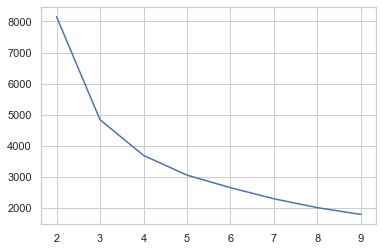

In [23]:
plt.plot(range(2,10,1), scores)
plt.xticks(ticks=range(2,10))

In [24]:
for i  in range(2,10):
    kmeans = KMeans(n_clusters=i, max_iter=40).fit(scaled_values)
    cluster_labels=kmeans.labels_
    silhouette_avg = silhouette_score(scaled_values, cluster_labels)
    print('For n_cluster{} the silhouette score is {}'.format(i, silhouette_avg))

For n_cluster2 the silhouette score is 0.5484059345049624
For n_cluster3 the silhouette score is 0.515263490702985
For n_cluster4 the silhouette score is 0.487680560036969
For n_cluster5 the silhouette score is 0.4859416819670123
For n_cluster6 the silhouette score is 0.4315274209311445
For n_cluster7 the silhouette score is 0.43186293763425093
For n_cluster8 the silhouette score is 0.3888923625066928
For n_cluster9 the silhouette score is 0.3871281952053017


In [25]:
kmeans = KMeans(n_clusters=3, max_iter=60).fit(scaled_values)
clusters = kmeans.labels_

In [26]:
customer_details['Cluster']  = clusters

c:\users\dd\onedrive\documents\_github\unsupervised-k-means-clustering\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
customer_details.shape
customer_details.head(100)

(4317, 5)

,Customer ID,Invoice,Total,Last Active,Cluster
0,12346.0,46,-6.468000e+01,66,1
1,12347.0,71,1.323320e+03,2,1
2,12348.0,20,2.221600e+02,73,1
3,12349.0,107,2.646990e+03,42,1
4,12351.0,21,3.009300e+02,10,1
5,12352.0,18,3.438000e+02,10,1
6,12353.0,20,3.177600e+02,43,1
7,12355.0,22,4.882100e+02,202,0
8,12356.0,84,3.562250e+03,15,1
9,12357.0,165,1.207999e+04,23,2


<AxesSubplot:xlabel='Cluster', ylabel='Total'>

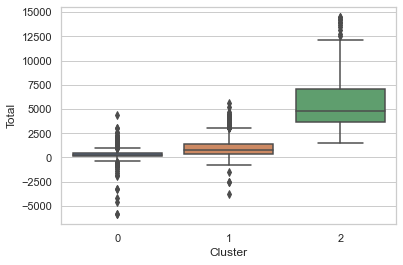

In [28]:
sns.boxplot(x='Cluster', y='Total', data=customer_details)

<AxesSubplot:xlabel='Cluster', ylabel='Last Active'>

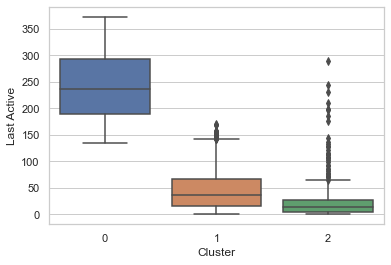

In [29]:
sns.boxplot(x='Cluster', y='Last Active', data=customer_details)

<AxesSubplot:xlabel='Cluster', ylabel='Invoice'>

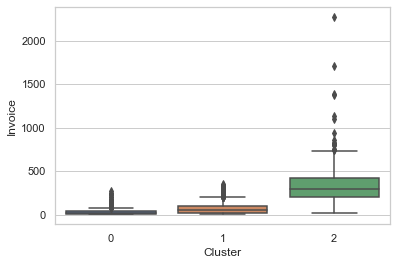

In [30]:
sns.boxplot(x='Cluster', y='Invoice', data=customer_details)